(c) 2024 Manuel Razo. This work is licensed under a [Creative Commons
Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/).
All code contained herein is licensed under an [MIT
license](https://opensource.org/licenses/MIT).

In [127]:
# Import project package
import Antibiotic

# Import libraries to handel data
import CSV
import DataFrames as DF
import Glob

# Import Flux 
import Flux
import Flux: mse

# Import basic math
import LinearAlgebra
import StatsBase
import Random
Random.seed!(42)

# Import Plotting libraries
using CairoMakie
import ColorSchemes

# Activate backend
CairoMakie.activate!()

# Set Plotting style
Antibiotic.viz.theme_makie!()

`[explanation here]`

Let's begin loading the data.

In [2]:
# Define data directory
data_dir = "$(git_root())/data/Iwasawa_2022"

# Load file into memory
df_ic50 = CSV.read("$(data_dir)/iwasawa_ic50_tidy.csv", DF.DataFrame)

# Locate strains with missing values
missing_strains = unique(df_ic50[ismissing.(df_ic50.log2ic50), :strain])

# Remove data
df_ic50 = df_ic50[[x ∉ missing_strains for x in df_ic50.strain], :]

# Group data by strain and day
df_group = DF.groupby(df_ic50, [:strain, :day])

# Extract unique drugs to make sure the matrix is built correctly
drug = sort(unique(df_ic50.drug))

# Initialize matrix to save ic50 values
ic50_mat = Matrix{Float32}(undef, length(drug), length(df_group))

# Loop through groups
for (i, data) in enumerate(df_group)
    # Sort data by stress
    DF.sort!(data, :drug)
    # Check that the stress are in the correct order
    if all(data.drug .== drug)
        # Add data to matrix
        ic50_mat[:, i] = Float32.(data.log2ic50)
    else
        println("group $i stress does not match")
    end # if
end # for

# Define number of environments
n_env = size(ic50_mat, 1)
# Define number of samples
n_samples = size(ic50_mat, 2)

# Fit model to standardize data to mean zero and standard deviation 1 on each
# environment
dt = StatsBase.fit(StatsBase.ZScoreTransform, ic50_mat, dims=2)

# Center data to have mean zero and standard deviation one
ic50_std = StatsBase.transform(dt, ic50_mat)

8×1269 Matrix{Float32}:
 -0.549695  -0.636041  -0.645549  …  -0.52737   -0.567254  -0.489156
  0.127085   0.396026   0.422921      0.152449   0.106901   0.0836802
 -0.952641  -0.814063  -0.947413     -0.712676  -0.723125  -0.706011
  0.434811  -0.480968  -0.244397      0.702219   0.484944   0.544966
 -0.469319  -0.463574  -0.461562     -0.450975  -0.278867  -0.296857
  0.689883   0.638487   0.126388  …   0.910045   0.774161   0.968758
  0.22606    0.13382    0.396659     -0.436597  -0.589569  -0.649776
 -0.605906  -0.748028  -0.533354     -0.860089  -1.17661   -0.934113

## PCA on the full data set

Let's begin by performing PCA on the data, we will do this via SVD.

In [53]:
# Perform SVD on the data
ic50_svd = LinearAlgebra.svd(ic50_std)

# Extract principal components
pcs = ic50_svd.U

# Convert singular values to explained variance
ic50_var = ic50_svd.S .^ 2 / (n_samples - 1)

# Compute explained variance percentage
ic50_var_pct = ic50_var / sum(ic50_var);

Let's look at the percentage of variance explained by each principal component.

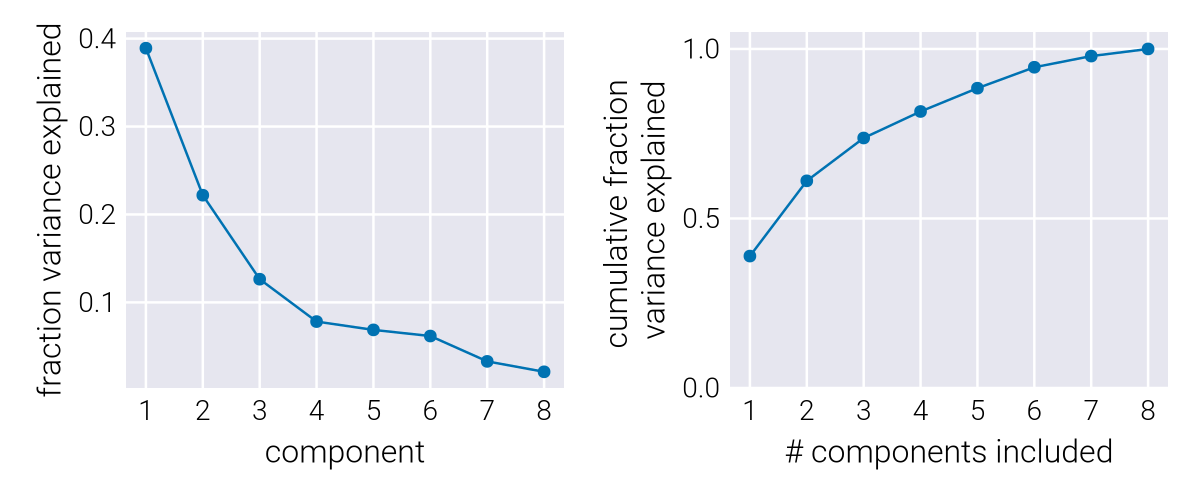

In [54]:
# Initialize figure
fig = Figure(size=(600, 250))

# Add axis
ax1 = Axis(
    fig[1, 1],
    xlabel="component",
    ylabel="fraction variance explained",
    xticks=1:n_env,
)

# Plot explained variance
scatterlines!(ax1, 1:n_env, ic50_var_pct)

# Add axis
ax2 = Axis(
    fig[1, 2],
    xlabel="# components included",
    ylabel="cumulative fraction \nvariance explained",
    xticks=1:n_env,
)

# Plot cumulative explained variance
scatterlines!(ax2, 1:n_env, cumsum(ic50_var_pct))

# Set y axis limits
ylims!(ax2, [0, 1.05])

fig

We can see that the first two principal componets explain ≈ 60% of the variance
in the data. Now, let's plot the mean squared error for the reconstruction.


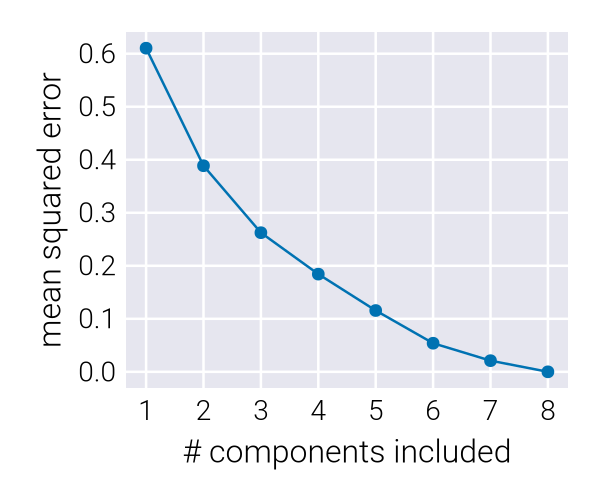

In [13]:
# Compute mean squared error of the data reconstruction
pca_mse = [
    begin
        # Compute the reconstruction of the data
        ic50_recon = pcs[:, 1:i] * (pcs[:, 1:i]' * ic50_std)
        # Compute the mean squared error
        mse(ic50_std, ic50_recon)
    end for i in 1:n_env
]

# Initialize figure
fig = Figure(size=(300, 250))

# Add axis
ax = Axis(
    fig[1, 1],
    xlabel="# components included",
    ylabel="mean squared error",
    xticks=1:n_env,
)

# Plot explained variance
scatterlines!(ax, 1:n_env, pca_mse)

fig

To project the data into the first two principal components, we need to build a
dataframe that contains the PC projections along with the metadata for each
sample.

In [55]:
# Project data to the first two principal components
data_pca = pcs[:, 1:2]' * ic50_std

# Convert data to DataFrame
df_pca = DF.DataFrame(
    data_pca',
    [:pc1, :pc2],
)

# Extract strains as ordered in ic50 matrix
strains_mat = [x.strain for x in keys(df_group)]
day_mat = [x.day for x in keys(df_group)]

# Add strains and days to DataFrame
DF.insertcols!(
    df_pca,
    :strain => strains_mat,
    :day => day_mat
)

# Add corresponding metadata resistance value
DF.leftjoin!(
    df_pca,
    unique(df_ic50[:, [:strain, :day, :parent, :env]]),
    on=[:strain, :day]
)

# Flip the sign of the first principal component to match the original
# publication
df_pca.pc1 = -df_pca.pc1

first(df_pca, 5)

Row,pc1,pc2,strain,day,parent,env
,Float32,Float32,String31,Int64,String7,String7
1,-0.245872,-0.0521469,Parent in TET 1,1,Parent,TET
2,-0.00629889,0.0583176,Parent in TET 1,2,Parent,TET
3,-0.0657993,0.312735,Parent in TET 1,3,Parent,TET
4,0.366908,0.790209,Parent in TET 1,4,Parent,TET
5,-0.542953,0.436027,Parent in TET 1,5,Parent,TET


Note that we inverted the sign of the first principal component to match the
original publication. This is a correct thing to do since the principal
components are defined up to a sign.

Now, let's look at the distribution of the data in the first two principal
components.

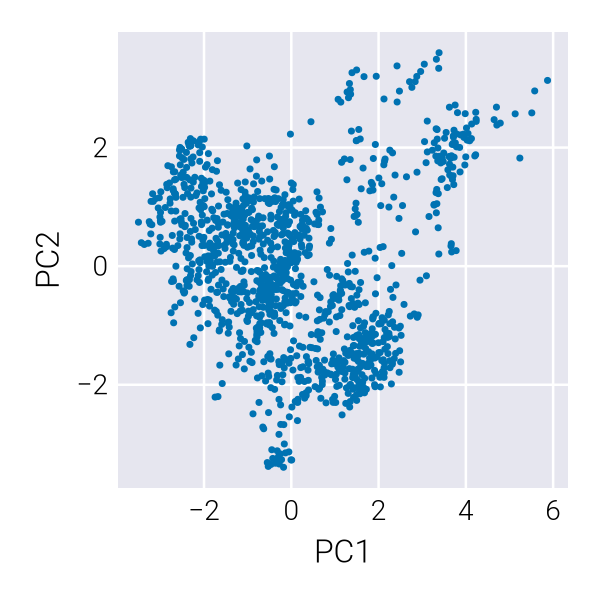

In [56]:
# Initialize figure
fig = Figure(size=(300, 300))

# Add axis
ax = Axis(fig[1, 1], xlabel="PC1", ylabel="PC2")

# Plot data
scatter!(ax, df_pca.pc1, df_pca.pc2, markersize=5)

fig

Let's repeat this plot, but now, let's color the data points by the environment
in which they evolved.

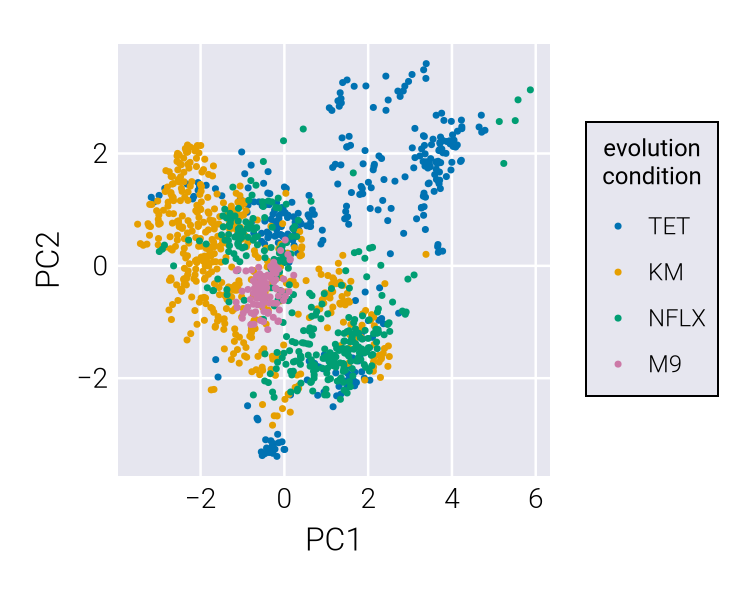

In [29]:
# Initialize figure
fig = Figure(size=(375, 300))

# Add axis
ax = Axis(fig[1, 1], xlabel="PC1", ylabel="PC2", aspect=AxisAspect(1))

# Group PCA data by :env
df_group_pca = DF.groupby(df_pca, :env)

# Loop through groups
for data in df_group_pca
    # Plot data
    scatter!(
        ax,
        data.pc1,
        data.pc2,
        markersize=5,
        label=first(data.env)
    )
end

# Add legend
leg = Legend(fig[1, 2], ax, "evolution\ncondition", labelsize=12, titlesize=12)

# Loop through groups
fig

## Trajectories in PC space

Let's look at the trajectories of the different environments in the first two
principal components.

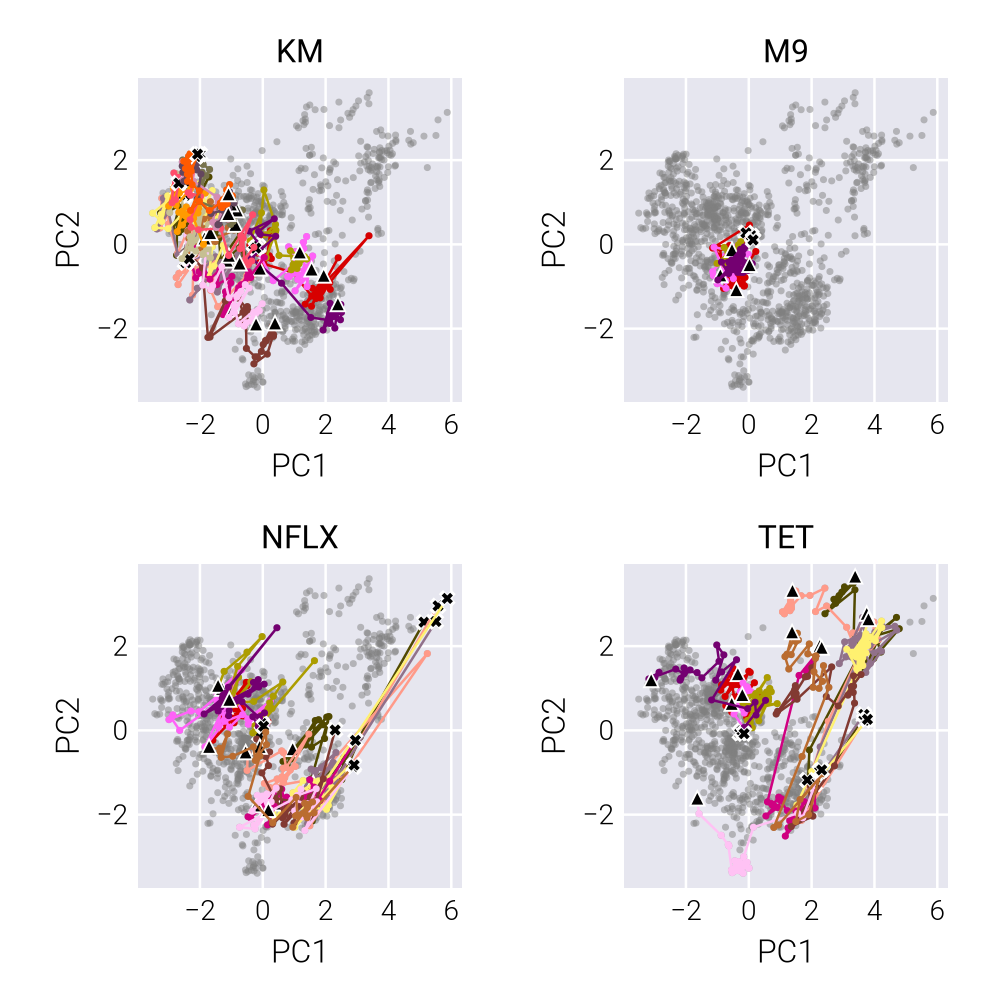

In [44]:
# Extract unique evolution environments
envs = sort(unique(df_pca.env))

# Initialize figure
fig = Figure(size=(500, 500))

# Add axes
axes = [
    Axis(
        fig[i, j],
        xlabel="PC1",
        ylabel="PC2",
        aspect=AxisAspect(1)
    ) for i in 1:2 for j in 1:2
]

# Loop through environments
for (i, env) in enumerate(envs)
    # Add ax title
    axes[i].title = env
    # Plot data as gray background
    scatter!(axes[i], df_pca.pc1, df_pca.pc2, markersize=5, color=(:gray, 0.5))

    # Extract data for the environment
    data = df_pca[df_pca.env.==env, :]

    # Group data by strain
    data_group = DF.groupby(data, :strain)

    # Loop through groups
    for (j, d) in enumerate(data_group)
        # Sort data by day
        DF.sort!(d, :day)
        # Plot data
        scatterlines!(
            axes[i],
            d.pc1,
            d.pc2,
            markersize=5,
            color=ColorSchemes.glasbey_bw_minc_20_hue_330_100_n256[j]
        )

        # Add first point 
        scatter!(
            axes[i],
            [d.pc1[1]],
            [d.pc2[1]],
            color=:white,
            markersize=12,
            marker=:xcross
        )
        scatter!(
            axes[i],
            [d.pc1[1]],
            [d.pc2[1]],
            color=:black,
            markersize=8,
            marker=:xcross
        )

        # Add last point
        scatter!(
            axes[i],
            [d.pc1[end]],
            [d.pc2[end]],
            color=:white,
            markersize=12,
            marker=:utriangle
        )
        scatter!(
            axes[i],
            [d.pc1[end]],
            [d.pc2[end]],
            color=:black,
            markersize=8,
            marker=:utriangle
        )
    end # for
end # for

fig

## "Fitness landscape" on PCA space

Let's repeat the previous plot, but now let's color the data points by the
fitness on each environment.

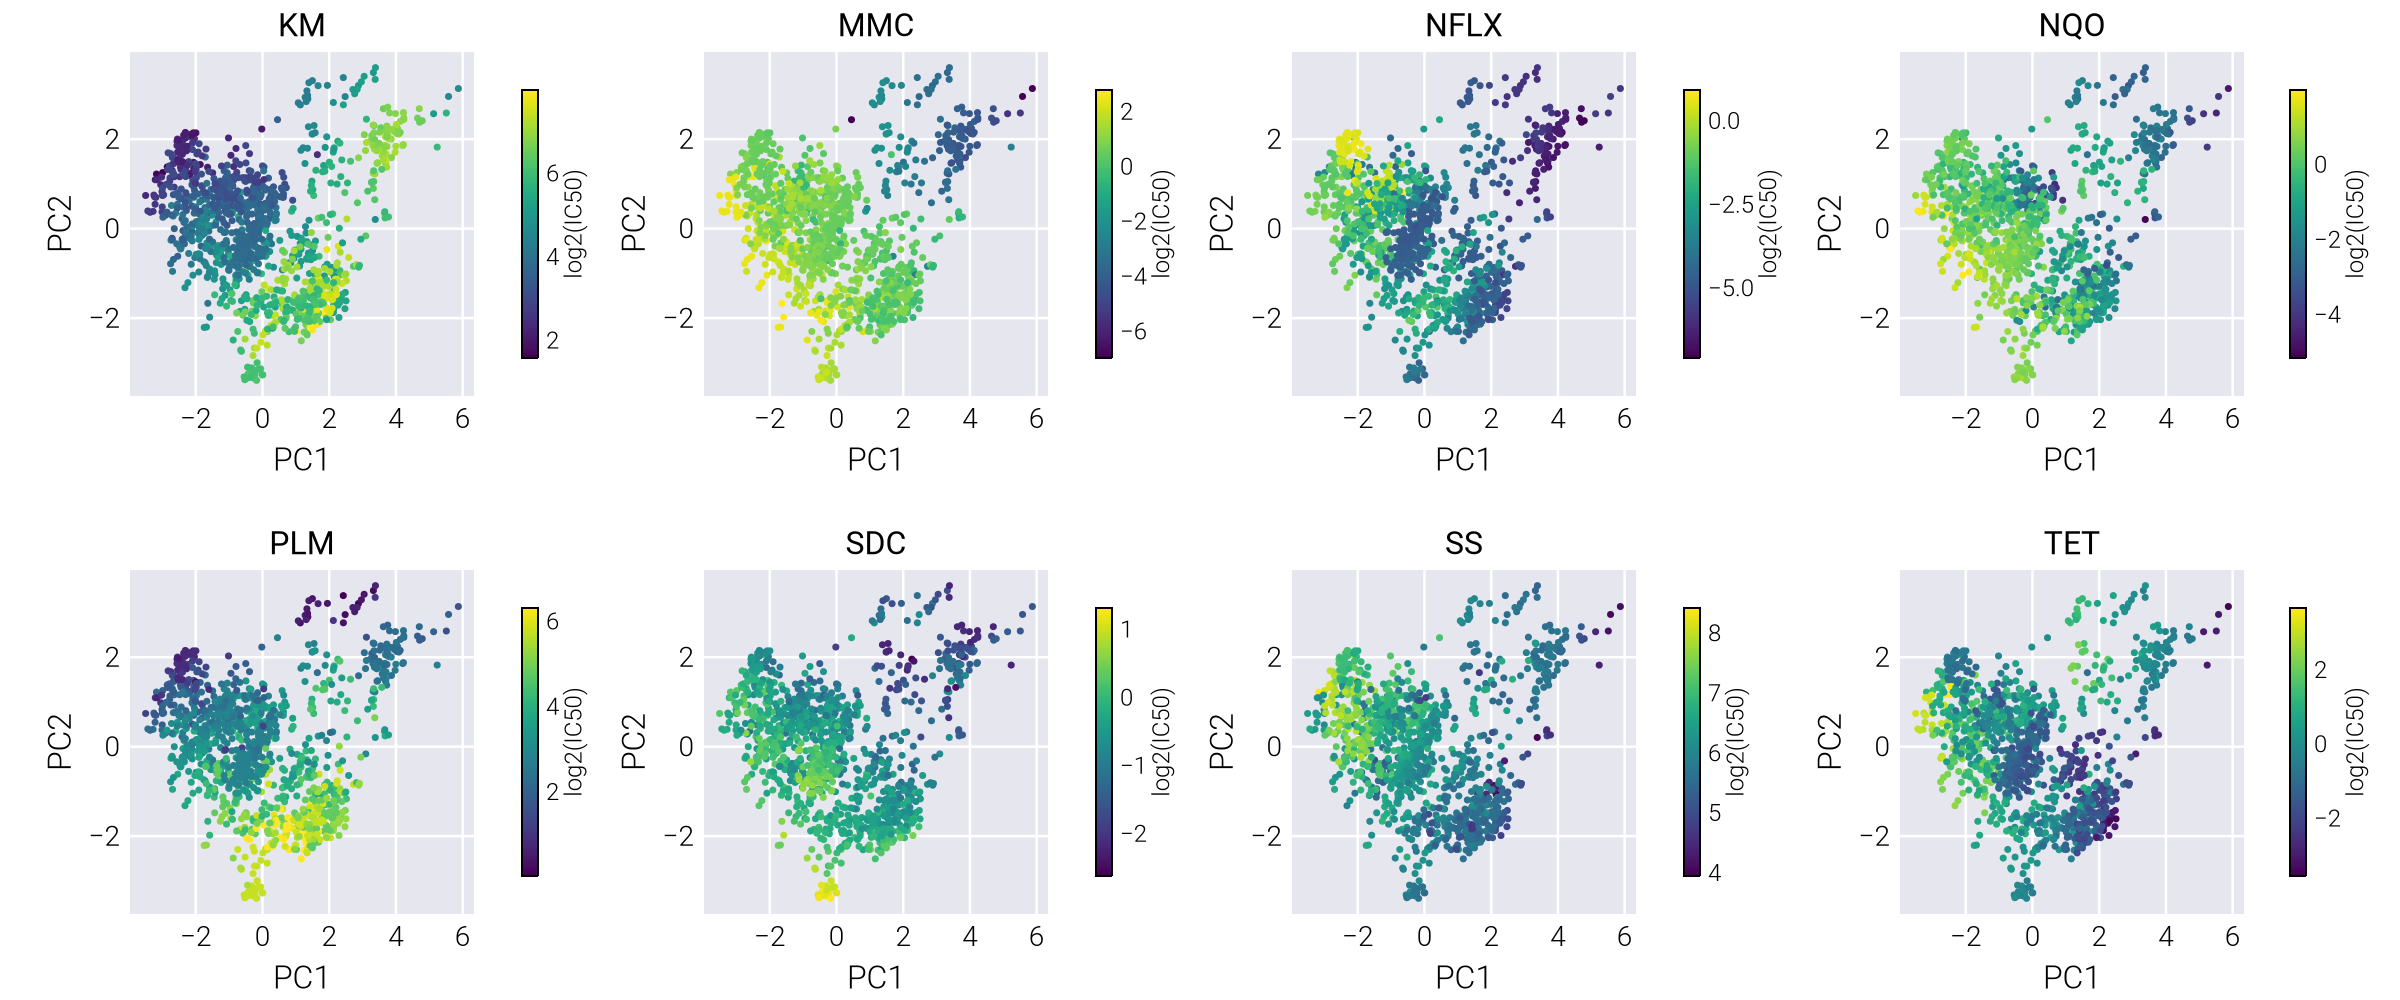

In [123]:
# Extract unique drugs to make sure the matrix is built correctly
drugs = sort(unique(df_ic50.drug))

# Initialize figure
fig = Figure(size=(1200, 500))

# Define number of rows and columns
rows = 2
cols = 4

# Add Grid Layout
gl_global = fig[1, 1] = GridLayout()

# Loop through unique drugs
for (i, drug) in enumerate(drugs)
    # Calculate row and column indices
    row = (i - 1) ÷ cols + 1
    col = (i - 1) % cols + 1

    # Add Grid Layout for ax
    gl = gl_global[row, col] = GridLayout()

    # Add axis
    ax = Axis(
        gl[1:10, 1],
        xlabel="PC1",
        ylabel="PC2",
        aspect=AxisAspect(1),
        title=drug
    )

    # Extract ic50 data for the drug
    data_ic50 = df_ic50[df_ic50.drug.==drug, :]
    # Copy PCA data temporarily
    data_pca = deepcopy(df_pca)
    # Merge dataframes to have IC50 and PCA data
    DF.leftjoin!(
        data_pca, data_ic50, on=[:strain, :day, :parent, :env]
    )

    # Plot data as gray background
    sca = scatter!(
        ax,
        data_pca.pc1,
        data_pca.pc2,
        markersize=5,
        color=Float32.(data_pca.log2ic50),
        colormap=:viridis
    )

    # Add colorbar
    cb = Colorbar(
        gl[2:9, 2],
        sca,
        size=8,
        label="log2(IC50)",
        labelsize=12,
        labelpadding=0.0,
        ticklabelsize=12,
        ticksvisible=false
    )
end # for

colgap!(gl_global, 10)
rowgap!(gl_global, 50)

fig

## Mean squared error for the reconstruction of out-of-sample data

To compare the ability of the PCA to reconstruct the data, we will split the
data into a training and a test set. We will train the PCA on the training set
and then reconstruct the test set. We will then calculate the mean squared error
for the reconstruction.

We will repeat this process multiple times to get a distribution of the mean
squared error on in-sample and out-of-sample data.

In [130]:
# Define splitting fraction
split_frac = 0.85
# Define number of bootstrap samples
n_samples = 1_000

# Initialize dataframe to save bootstrap results
df_boots = DF.DataFrame()

# Set random seed
Random.seed!(42)

# Loop through bootstrap samples
for s in 1:n_samples
    # Split data into training and testing
    train_data, val_data = Flux.splitobs(ic50_std, at=split_frac, shuffle=true)

    # Perform SVD on the data
    train_svd = LinearAlgebra.svd(train_data)
    # Extract principal components
    pcs = train_svd.U

    # Compute mean squared error of the train data reconstruction
    train_pca_mse = [
        begin
            # Compute the reconstruction of the training data
            train_recon = pcs[:, 1:i] * (pcs[:, 1:i]' * train_data)
            # Compute the mean squared error
            mse(train_data, train_recon)
        end for i in 1:n_env
    ]

    # Compute mean squared error of the validation data reconstruction
    val_pca_mse = [
        begin
            # Compute the reconstruction of the validation data
            val_recon = pcs[:, 1:i] * (pcs[:, 1:i]' * val_data)
            # Compute the mean squared error
            mse(val_data, val_recon)
        end for i in 1:n_env
    ]

    # Initialize temporary dataframe
    df_tmp = DF.DataFrame(
        mse_train=train_pca_mse,
        mse_val=val_pca_mse,
        pcs=1:n_env,
        sample=s
    )

    # Append temporary dataframe to the main dataframe
    DF.append!(df_boots, df_tmp)
end # for

first(df_boots, 5)

Row,mse_train,mse_val,pcs,sample
,Float32,Float32,Int64,Int64
1,0.613332,0.594405,1,1
2,0.38931,0.386585,2,1
3,0.262239,0.264446,3,1
4,0.184795,0.183814,4,1
5,0.115304,0.119535,5,1


Let's now plot the distribution of the mean squared error for the in-sample and
out-of-sample data.

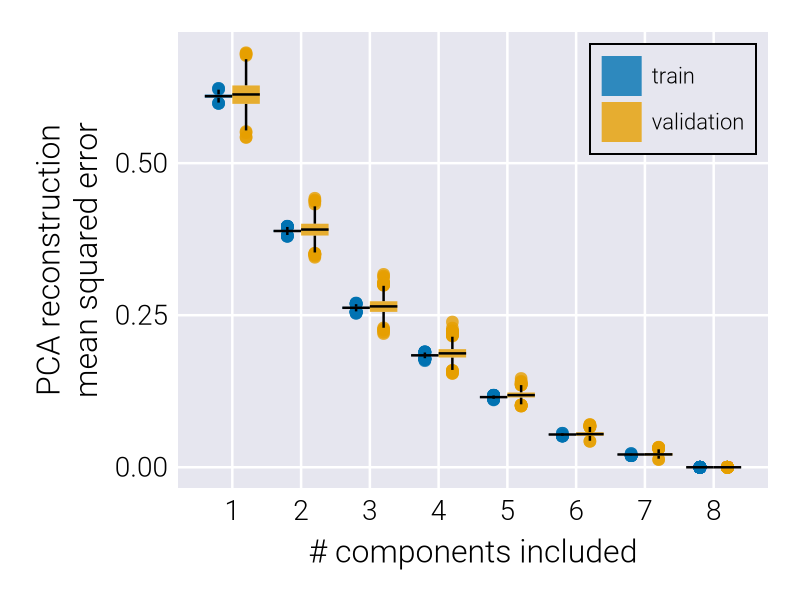

In [161]:
# Initialize figure
fig = Figure(size=(400, 300))

# Add axis
ax = Axis(
    fig[1, 1],
    xlabel="# components included",
    ylabel="PCA reconstruction\nmean squared error",
    xticks=1:n_env,
)

# Boxplot of the MSE in training data
boxplot!(
    ax, df_boots.pcs .- 0.2, df_boots.mse_train, label="train", width=0.5
)
# Boxplot of the MSE in validation data
boxplot!(
    ax, df_boots.pcs .+ 0.2, df_boots.mse_val, label="validation", width=0.5
)

# Add legend
axislegend(ax, position=:rt, labelsize=11)

fig